# Проект по непрерывной оптимизации
## Программный код


In [0]:
import numpy as np
import scipy.linalg as li
import matplotlib.pyplot as plt

from dataclasses import dataclass

# в данной работе используется евклидова норма

def norm(v):
	return np.sqrt(np.sum(np.square(v)))

### 1. Алгоритм Голуба-Кахана бидиагонализации матрицы

Вход: матрица $A$ размера $m$ на $n$.

Выход: матрицы $U$, $B$, $V$, где $U$ и $V$ — ортогональные, $B$ — бидиагональная.

In [0]:
def is_bidiagonalized(A):
  n, m = A.shape
  for i in range(n):
    for j in range(m):
      if abs(A[i][j]) > 1e-6 and i != j and i != j - 1:
        return False
  return True

In [0]:
def bidiagonalize(A):
	m, n = A.shape
	if is_bidiagonalized(A):
		U = np.identity(m)
		V = np.identity(n)
		return U.astype("float64"), A.astype("float64"), V.astype("float64")

	V = np.zeros((n, n))
	U = np.zeros((m, m))
	B = np.zeros((m, n))
 
  # construct unit vector
	v = np.zeros(n)
	v[0] = 1.0
	V[:, 0] = v

  # u will be defined later
	u = np.zeros(m)

	alpha, beta = 0, 0

	for k in range(m):
		u = np.dot(A, v) - beta * u
		alpha = norm(u)
		B[k][k] = alpha
		if alpha != 0:
			u = u / alpha
		U[:, k] = u
		v = np.dot(A.T, u) - alpha * v
		beta = norm(v)
		if beta != 0:
			v = v / beta
		if k + 1 < n:
			B[k][k + 1] = beta
			V[:, k + 1] = v

#	print("get A:", A)
#	print("make U:", U, "V:", V, "B:", B)
	return U, B, V

Проверим на матрице 3х3, что алгоритм бидиагонализации Голуба-Кахана работает, т.е. что полученная матрица B достаточно близка к $U^T \cdot A \cdot V$, а $U$ и $V$ имеют единичные определители по модулю.

In [0]:
A = np.array([[1, 2, 1], [4, 5, 6], [7, 8, 9]])
U, B, V = bidiagonalize(A)
print(np.linalg.det(U), np.linalg.det(V)) # ортогональность
print(A, B, np.dot(np.dot(U.T, A), V), sep="\n")

-1.0 -0.9999999999999998
[[1 2 1]
 [4 5 6]
 [7 8 9]]
[[ 8.1240384  14.47463822  0.        ]
 [ 0.          0.85634679  0.08782624]
 [ 0.          0.          0.86244142]]
[[ 8.12403840e+00  1.44746382e+01 -1.00284430e-11]
 [-2.57571742e-14  8.56346791e-01  8.78262407e-02]
 [-9.44594541e-11 -1.68748475e-10  8.62441424e-01]]


Алгоритм действительно выдал ортогональные матрицы и работает на данном примере.

Теперь запустим алгоритм на 1000 случайных матрицах $A \in Mat_{10 \times 10}(\mathbb{R})$, элементы которой равномерно распределены в $(0, 1]$, и проверим, насколько произведение $U^T A V$ отличается от полученной бидиагональной матрицы $B$.

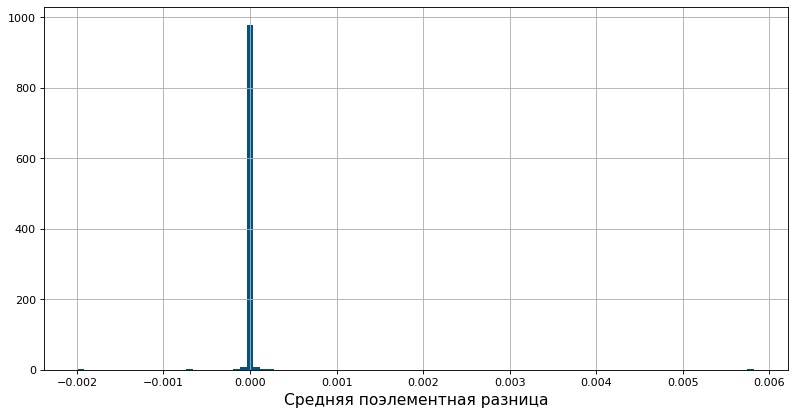

In [0]:
res = []
for i in range(1000):
    A = np.random.rand(7, 10)
    U, B, V = bidiagonalize(A)
    B_test = np.dot(np.dot(U.T, A), V)
    res.append((B_test - B).mean())

fig = plt.figure(dpi=80, figsize=(12, 6))
plt.xlabel("Средняя поэлементная разница", fontsize=14)
plt.grid(True)
plt.hist(res, bins=100, color="xkcd:deep sea blue")
plt.show()
#fig.savefig("test_golub_kahan_7x10_mean.pdf")

Полученная средняя поэлементная разница практически во всех случаях нулевая, с уменьшением размерности "хвост" распределения этой величины уменьшается.

### 2. Оракулы для получения значений функций в точке и значений градиента

In [0]:
#f(x) = x^2 - x

@dataclass
class Oracle:
  def f_1(self, x):
    '''
    returns F(x) norm
    '''
    return np.sqrt(np.sum(np.square(self.F(x))))

  def F(self, x):
    '''
    computes the value of function at point x
    '''
    x = x[:, 0]
    return np.array([[x[0]**2 - x[0]]])

  def dF(self, x):
    '''
    computes the value of the function's derivative at point x
    '''
    x = x[:, 0]
    return np.array([[2 * x[0] - 1]])

  def shape(self):
    return (1, 1)

In [0]:
# f(x, y) = (x^2 - 2x + 1) + (y^2 + 5y - 6) + 10

@dataclass
class Oracle2:
  def f_1(self, x):
    '''
    returns F(x) norm
    '''
    return np.sqrt(np.sum(np.square(self.F(x))))

  def F(self, x):
    
    '''
    computes the value of function at point x
    '''
    x = x[:,0]
    return np.array([[x[0]**2 - 2 * x[0] + 1 + x[1]**2 + 5 * x[1] - 6]])

  def dF(self, x):
    '''
    computes the value of the function's derivative at point x
    '''
    x = x[:,0]
    return np.array([[2 * x[0] - 2, 2 * x[1] + 5]])

  def shape(self):
    return (1, 2)

In [0]:
# f(x, y) = x^4 - x + y^4 - 2y^2 + 1

@dataclass
class Oracle3:
  def f_1(self, x):
    '''
    returns F(x) norm
    '''
    return np.sqrt(np.sum(np.square(self.F(x))))

  def F(self, x):
    
    '''
    computes the value of function at point x
    '''
    x = x[:,0]
    return np.array([[x[0]**4 - x[0] + x[1]**4 - 2 * x[1]**2 + 1]])

  def dF(self, x):
    '''
    computes the value of the function's derivative at point x
    '''
    x = x[:,0]
    return np.array([[4 * x[0]**3 - 1, 4 * x[1]**3 - 4 * x[1]]])

  def shape(self):
    return (1, 2)

In [0]:
# f(x, y) = ( (x - 2y)^2, y^2 ) 

@dataclass
class Oracle4:
  def f_1(self, x):
    '''
    returns F(x) norm
    '''
    return np.sqrt(np.sum(np.square(self.F(x))))

  def F(self, x):
    
    '''
    computes the value of function at point x
    '''
    x = x[:,0]
    return np.array([[(x[0] - 2 * x[1])**2], [x[1]**2]])

  def dF(self, x):
    '''Rosenbrock
    computes the value of the function's derivative at point x
    '''
    x = x[:,0]
    return np.array([[ 2*(x[0] - 2 * x[1]), -4*(x[0] - 2 * x[1]) ], [ 0, 2 * x[1] ]])

  def shape(self):
    return (2, 2)

### 3. Модификация градиентного метода Гаусса-Ньютона 

Вспомогательные функции, в том числе минимизация $\hat\psi$:

In [0]:
def psi(oracle, x, y, i, L):
  return phi(oracle, x, y) + 2 ** (i - 1) * L * np.sum(np.square(y - x))


def hat_psi(oracle, x, y, i, L):
  f1 = oracle.f_1(x)
  return L / 2 * np.sum(np.square(y - x)) + 1 / (2 * f1) * (f1 * f1 + np.sum(np.square(oracle.F(x) + oracle.dF(x) * (y - x))) )


def get_hat_psi_argmin(oracle, x, i, L):
  n, m = oracle.shape()
  new_L = 2**i * L
  dF = oracle.dF(x)
  U, B, V = bidiagonalize(dF)
  f_1 = oracle.f_1(x)
  dFtdF = dF.T @ dF
  b = new_L * f_1 * x + dFtdF @ x - dF.T @ oracle.F(x)
  tridiagonal_matrix = B.T @ B
  tridiagonal_matrix += new_L * f_1 * np.eye(tridiagonal_matrix.shape[0])
  T = (V.T @ li.inv(tridiagonal_matrix) @ V) @ b
  return T


Непосредственно градиентный спуск:

In [0]:
@dataclass
class GradientDescent():

  def do_gd(self, oracle, start_point, eps, L0, rule, verbose=False):
    n, m = oracle.shape()

    def T(x, L):
#      print(x)
      F_cnt = oracle.F(x)
      i = 0
      result = None
      while 1:
        # calculate T = argmin(psi(i, L, f))
        result = get_hat_psi_argmin(oracle, x, i, L)
        # find the smallest i for which the inequality is satisfied
        if oracle.f_1(result) < hat_psi(oracle, x, result, i, L):
          break
        i += 1
      return result, L * 2**(i - 1)

    x = np.array(start_point).reshape((m, 1))
    z = np.zeros((m, 1)) # zero vector

    X = [x]
    y, L = T(X[0], L0)
#    print("Starting:", y)
    Y = [x, y]

    k = 0
    while True:
      k += 1
      if verbose:
        print("\nSTEP", k)

      y = Y[k]
      if verbose:
        print("current point is", y[:,0], " ||F|| =", oracle.f_1(y))
      x, L = T(y, L) # (a)
      if norm(y - x) <= eps:
        break

      if verbose:  
        print("||y-x|| =", norm(y - x))


      X.append(x)

      psi = lambda tau: oracle.f_1(X[k - 1] + tau * (X[k] - X[k - 1])) # (b)
      def d_psi(tau): # psi derivative
        delta_x = X[k] - X[k - 1]
        h = X[k - 1] + tau * delta_x
        return (oracle.F(h).T @ oracle.dF(h) @ delta_x) / psi(tau) #???

      # (c)
      tau = 1
      if rule == 'armijo':
        alpha = 1/3
        beta = 2/3
        psi0 = psi(0)
        d_psi0 = d_psi(0)

        cond61 = lambda tau: psi0 + beta * d_psi0 * tau <= psi(tau) <= psi0 + alpha * d_psi0 * tau
        cond621 = lambda tau: psi0 + beta * d_psi0 * tau > psi(tau)
        cond622 = lambda tau: psi0 + alpha * d_psi0 * tau < psi(tau)

        if verbose:  
          print("start localization")

        # localization stage
        tau1, tau2 = 1, 1
        if not cond61(tau):
          assert(cond621(tau) or cond622(tau))
          if cond621(tau):
            tau1 = 1
            tau2 = 2 * tau1
          else:
            tau2 = 1
            tau1 = tau2 / 2
        
          while not (cond621(tau1) and cond622(tau2)):
            if verbose:
              print(tau1, cond621(tau1), tau2, cond622(tau2))            
            if cond621(tau1) and (not cond622(tau2)):
              tmp = tau1
              tau1 = tau2
              tau2 = 2 * tmp
            elif cond622(tau2) and (not cond621(tau1)):
              tmp = tau2
              tau2 = tau1
              tau1 = tmp / 2
            elif (not cond621(tau1)) and (not cond622(tau2)):
              raise RuntimeError
        
          if verbose:  
            print("start specification", tau1, tau2, L0)

          # specification stage
          assert(cond621(tau1) and cond622(tau2))

          tau = (tau1 + tau2) / 2
          while not cond61(tau):
            if cond621(tau) and (not cond622(tau)):
              tau1 = tau
            elif (not cond621(tau)) and cond622(tau):
              tau2 = tau
            else:
              raise RuntimeError
            tau = (tau1 + tau2) / 2
        
          if verbose:
            print("armijo rule done")

      elif rule == 'extrapolation':
        taus = [0, 1]

        i = 1
        while d_psi(taus[i]) < 0 and psi(taus[i]) <= psi(taus[i - 1]):
          taus.append(2 * taus[-1])
          i += 1
        
        tau = taus[-1]
      
      else:
        raise RuntimeError

      # (d)
      Y.append(X[k - 1] + tau * (X[k] - X[k - 1]))
      #plt.plot([y[0, 0] for y in Y], [y[1, 0] for y in Y])

    return Y # full history

### 4. Проверка работы полученного метода

Рассмотрим влияние параметра $L_0$ на сходимость метода. Для этого запустим алгоритм на простой функции и построим график зависимости значения в найденном оптимуме $f(x^*)$ от $L_0$.

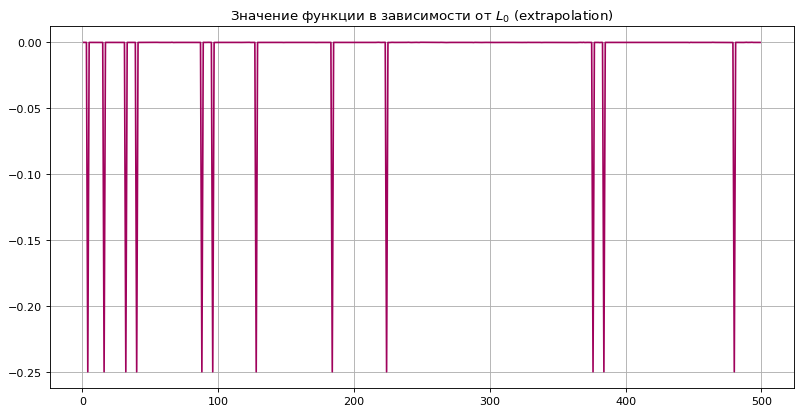

In [0]:
def main():
  oracle = Oracle()
  GD = GradientDescent()

  rule = "extrapolation"
  results = []
  L0s = np.arange(1, 500)
  for L0 in L0s:
    try:
      points_history = np.array(GD.do_gd(oracle, np.array([[20000]]), 0.0001, L0, rule, verbose=False))
      function_value_history = [oracle.F(x)[0,0] for x in points_history]
      ans = function_value_history[-1]
      results.append(ans)
#      print(L0, len(function_value_history))
    except:
      results.append(1) # метод не сошелся
  fig = plt.figure(dpi=80, figsize=(12, 6))
  plt.title("Значение функции в зависимости от $L_0$ ({})".format(rule))
  plt.plot(L0s, results, color="xkcd:deep magenta")
  plt.grid(True)
  plt.show()
  fig.savefig("momentum_{}_L0_1.pdf".format(rule))

main()

В данном случае метод с применением экстраполяции для выбора длины шага сходится практически при любом заданном значении $L_0$.

In [0]:
# f(x, y) = ( (x - 2y)^2, y^2 ) 

@dataclass
class OracleCGE:
  def __init__(self, n, alpha, beta, gamma, sigma):
    assert(len(alpha) == n + 1)
    assert(len(gamma) == n)

    self.n = n
    
    self.alpha_short = np.array(alpha[:n - 1]).reshape((n - 1, 1))
    
    self.alpha_n = alpha[n - 1]
    self.alpha_nx1 = alpha[n]

    self.beta_nx1 = beta
    self.sigma = sigma

    self.gamma = np.array(gamma).reshape((n, 1))
    self.gamma_short = self.gamma[:n - 1, 0:1]

  def f_1(self, point):
    '''
    returns F(x) norm
    '''
    return abs(self.F(point))

  def F(self, point):
    
    '''
    computes the value of function at point x
    '''
    n = self.n
    x_n, x_nx1 = point[n - 1, 0], point[n, 0]
    x_short = point[:n - 1, 0:1]
    
    # \beta_{n+1} * x_{n+1} - \sum_{i = 1}^n (\gamma_i * x_i)
    sum1 = self.beta_nx1 * x_nx1 - self.gamma.T @ point[:n, 0:1]
    
    cache = self.alpha_n * np.power(x_n, self.sigma) - self.alpha_nx1 * x_nx1

    return np.sum(np.square(x_short - self.alpha_short * x_nx1)) + cache**2 + sum1**2

  def dF(self, point):
    '''
    computes the value of the function's derivative at point x
    '''
    n = self.n
    x_n, x_nx1 = point[n - 1, 0], point[n, 0]
    x_short = point[:n - 1, 0:1]
    
    # \beta_{n+1} * x_{n+1} - \sum_{i = 1}^n (\gamma_i * x_i)
    sum1 = self.beta_nx1 * x_nx1 - self.gamma.T @ point[:n, 0:1]
    
    # (grad_1,  ..., grad_{n-1})
    grad_short = 2 * x_short - 2 * x_nx1 * self.alpha_short - 2 * self.gamma_short * sum1

    cache = self.alpha_n * np.power(x_n, self.sigma) - self.alpha_nx1 * x_nx1

    grad_n = 2 * self.alpha_n * self.sigma * np.power(x_n, self.sigma - 1) * cache - 2 * self.gamma[n - 1, 0] * sum1

    grad_nx1 = -2 * self.alpha_short.T @ (x_short - x_nx1 * self.alpha_short) - 2 * self.alpha_nx1 * cache + 2 * sum1 * self.beta_nx1

    result = np.vstack((grad_short, grad_n, grad_nx1))
    print(result.T)
    return result.T


  def shape(self):
    return (1, self.n + 1)

[[ 2  2 -2]]
[[ 2  2 -2]]

STEP 1
current point is 0.9358695652173912  ||F|| = [[5.25511106]]
[[ 5.61521739  5.61521739 -7.48695652]]
[[ 5.61521739  5.61521739 -7.48695652]]
||y-x|| = 0.0929279601010794
[[ 5.22095745  5.22095745 -6.9612766 ]]

STEP 2
current point is 0.8701595744680851  ||F|| = [[4.54306611]]
[[ 5.22095745  5.22095745 -6.9612766 ]]
[[ 5.22095745  5.22095745 -6.9612766 ]]
||y-x|| = 0.0807575653264776
[[ 4.87833211  4.87833211 -6.50444282]]
[[ 4.53570678  4.53570678 -6.04760904]]
[[ 3.85045612  3.85045612 -5.13394149]]
[[ 2.47995479  2.47995479 -3.30660638]]
[[-0.26104787 -0.26104787  0.34806383]]

STEP 3
current point is -0.043507978723402396  ||F|| = [[0.01135767]]
[[-0.26104787 -0.26104787  0.34806383]]
[[-0.26104787 -0.26104787  0.34806383]]
||y-x|| = 0.0007534233499845932
[[-0.26424438 -0.26424438  0.35232584]]

STEP 4
current point is -0.04404072948328075  ||F|| = [[0.01163752]]
[[-0.26424438 -0.26424438  0.35232584]]
[[-0.26424438 -0.26424438  0.35232584]]
||y-x||

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in subtract


[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675634e+107 -1.05675633e+107  1.40900845e+107]]
[[-1.05675

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


Streaming output truncated to the last 5000 lines.
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e+106 -1.36362082e+106  1.81816109e+106]]
[[-1.36362081e

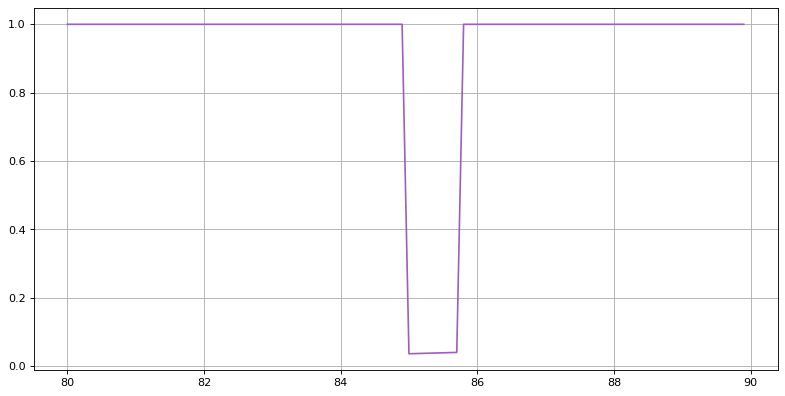

In [0]:
GD = GradientDescent()
oracle = OracleCGE(2, [1, 1, 1], 1, [1, 1], 1)
rule = "extrapolation"

result = []
L0s = np.arange(80, 90, 0.1)
for L0 in L0s:
  try:
    points_history = GD.do_gd(oracle, np.array([[1], [1], [1]]), 0.0001, L0, rule, verbose=False)
    function_value_history = [oracle.f_1(x)[0,0] for x in points_history]
    print(L0, function_value_history[-1])
    result.append(function_value_history[-1])
  except:
    result.append(1) # метод не сошелся
#    print(L0, "ooops")

fig = plt.figure(dpi=80, figsize=(12, 6))
plt.plot(L0s, result, color="xkcd:amethyst")
plt.grid(True)
plt.show()
fig.savefig("cge_{}_L0s.png".format(rule))

[[ 2  2 -2]]
[[ 2  2 -2]]
[[ 5.63468769  5.63468769 -7.51291692]]
[[ 5.63468769  5.63468769 -7.51291692]]
[[ 5.24610023  5.24610023 -6.99480031]]
[[ 5.24610023  5.24610023 -6.99480031]]
[[ 5.24610023  5.24610023 -6.99480031]]
[[ 4.88913822  4.88913822 -6.51885095]]
[[ 4.5321762  4.5321762 -6.0429016]]
[[ 3.81825217  3.81825217 -5.09100289]]
[[ 2.3904041   2.3904041  -3.18720547]]
[[-0.46529202 -0.46529202  0.62038937]]
[[-0.46529202 -0.46529202  0.62038937]]
[[-0.46529202 -0.46529202  0.62038937]]
0.036082777941954323 [[-0.07754867]
 [-0.07754867]
 [ 0.        ]]


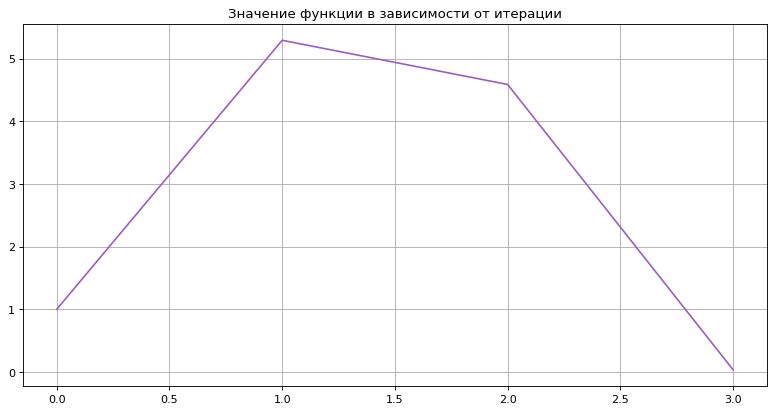

In [0]:
GD = GradientDescent()
oracle = OracleCGE(2, [1, 1, 1], 1, [1, 1], 1)
rule = "extrapolation"

points_history = GD.do_gd(oracle, np.array([[1], [1], [1]]), 0.0001, 85, rule, verbose=False)
function_value_history = [oracle.f_1(x)[0,0] for x in points_history]
print(function_value_history[-1], points_history[-1])

fig = plt.figure(dpi=80, figsize=(12, 6))
plt.title("Значение функции в зависимости от итерации")
plt.plot(function_value_history, color="xkcd:amethyst")
plt.grid(True)
plt.show()
fig.savefig("cge_{}_4.pdf".format(rule))

При хорошо подобранных входных параметрах метод куда-то сходится...

In [0]:
@dataclass
class OracleRosenbrock:
  def __init__(self, n):
    self.n = n

  def f_1(self, point):
    '''
    returns F(x) norm
    '''
    return abs(self.F(point))

  def F(self, point):
    
    '''
    computes the value of function at point x
    '''
    n = self.n
    x_1 = point[0, 0]
    res_sum = (x_1 - 1)**2 / 4
    for i in range(n-2):
      x_i = point[i, 0]
      x_ix1 = point[i+1, 0]
      res_sum += (x_ix1 - 2*x_i**2 + 1)**2
    return np.array([[res_sum]])

  def dF(self, point):
    '''
    computes the value of the function's derivative at point x
    '''
    n = self.n
    x_1 = point[0, 0]
    x_2 = point[1, 0]
    grad_1 = (x_1 - 1) / 2 + 16 * x_1**3 - 8 * x_1 * x_2 - 8 * x_1
    grad = [grad_1]
    for i in range(1, n-1):
      x_i = point[i, 0]
      x_ix1 = point[i+1, 0]
      grad_i = 16 * x_i - 8 * x_i * x_ix1 - 8 * x_i
      grad.append(grad_i)

    x_n = point[-1, 0]
    x_nm1 = point[-2, 0]
    grad_n = - 4 * x_nm1**2 + 2*x_n + 2
    grad.append(grad_n)
    return np.array([grad])

  def shape(self):
    return (1, self.n)


STEP 1
current point is [1.67164547 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.      

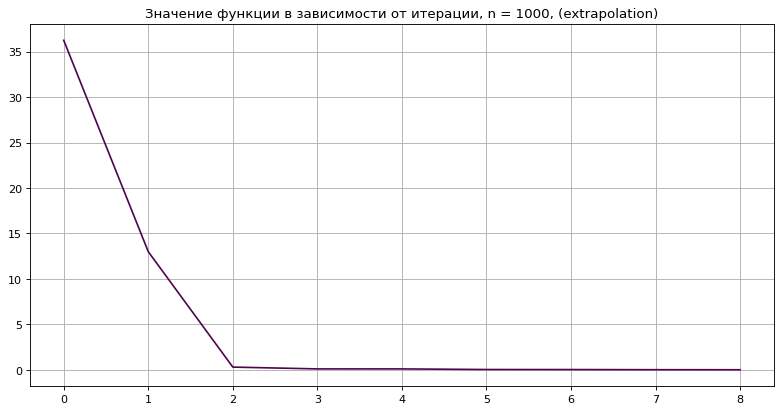

In [0]:
def main():
  n = 1000
  oracle = OracleRosenbrock(n)
  GD = GradientDescent()

  rule = "extrapolation"
  start_point = np.ones((n, 1))
  start_point[0,0] = 2
  points_history = np.array(GD.do_gd(oracle, start_point, 0.0001, 37, rule, verbose=True))
  function_value_history = [oracle.F(x)[0,0] for x in points_history]
  
  print("ans x:", points_history[-1][0], "ans f:", function_value_history[-1])
  fig = plt.figure(dpi=80, figsize=(12, 6))
  plt.title("Значение функции в зависимости от итерации, n = {}, ({})".format(n, rule))
  plt.plot(function_value_history, color="xkcd:plum purple")
  plt.grid(True)
  plt.show()
  fig.savefig("momentum_{}_L0_R.pdf".format(rule))

main()

In [0]:
def main():
  n = 1000
  oracle = OracleRosenbrock(n)
  GD = GradientDescent()

  rule = "extrapolation"
  start_point = np.ones((n, 1))
  start_point[0,0] = 2
  results = []
  L0s = np.arange(1, 500)
  for L0 in L0s: 
    try:
      points_history = np.array(GD.do_gd(oracle, start_point, 0.0001, L0, rule, verbose=False))
      function_value_history = [oracle.F(x)[0,0] for x in points_history]
      ans = function_value_history[-1]
      print(L0, ans, points_history[-1][0])
      results.append(ans)
    except:
      results.append(1) # не получилось

  fig = plt.figure(dpi=80, figsize=(12, 6))
  plt.title("Значение функции в зависимости от $L_0$ ({})".format(rule))
  plt.plot(L0s, results, color="xkcd:deep magenta")
  plt.grid(True)
  plt.show()
  fig.savefig("momentum_{}_L0_r.pdf".format(rule))

main()

1 1.3690743104191784e-11 [1.00000092]
8 3.619032004809444e-15 [1.00000001]
